## Set up

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import torch
import glob
import random
from tqdm import tqdm
import shutil

## Preprocess data

We extract the bounding box coordinates which will be used to feed into SAM as prompts.

In [4]:
bbox_coords = {}
im = cv2.imread('/media/rohit/mirlproject2/fetal head circumference/training_set/69_HC_Annotation.png')
gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
contours, hierarchy = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
if len(contours) > 1:
    x,y,w,h = cv2.boundingRect(contours[0])
    height, width, _ = im.shape
    bbox_coords['69_HC_Annotation'] = np.array([x, y, im.shape[1], im.shape[0]])

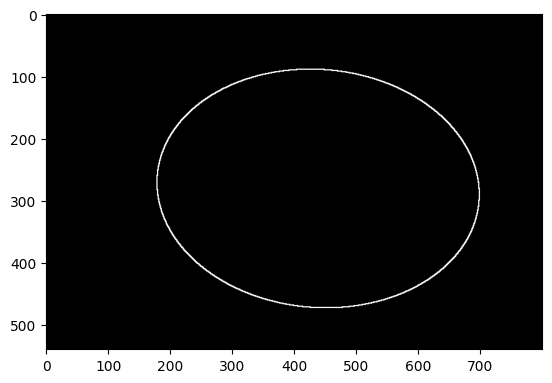

In [7]:
plt.imshow(im)

In [4]:
im.shape

(540, 800, 3)

In [8]:
bbox_coords

{'69_HC_Annotation': array([179,  89, 800, 540])}

In [5]:
bbox_coords = {}
im = cv2.imread('/media/rohit/mirlproject2/fetal head circumference/1segmented-images/segmented-images/masks/0b556d02-f9ca-4270-b568-3200335c7d08.jpg')
gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
contours, hierarchy = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
if len(contours) > 1:
    x,y,w,h = cv2.boundingRect(contours[0])
    height, width, _ = im.shape
    if (x+2*w<=width) and (y+2*h<=height):
        bbox_coords['0b556d02-f9ca-4270-b568-3200335c7d08'] = np.array([0, 0, w, h])
    elif (x+2*w>width) and (y+2*h<=height):
        bbox_coords['0b556d02-f9ca-4270-b568-3200335c7d08'] = np.array([0, 0, w, h])
    elif (x+2*w<=width) and (y+2*h>height):
        bbox_coords['0b556d02-f9ca-4270-b568-3200335c7d08'] = np.array([0, 0, w, h])
    else:
        #print("This")
        bbox_coords['0b556d02-f9ca-4270-b568-3200335c7d08'] = np.array([0, 0, w, h])

In [6]:
bbox_coords = {}
im = cv2.imread('/media/rohit/mirlproject2/fetal head circumference/1segmented-images/segmented-images/masks/2e86a9ba-6d50-4748-8a2b-8dd2c872220b.jpg')
gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
contours, hierarchy = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

largest_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest_contour)
bbox_coords = {'0b556d02-f9ca-4270-b568-3200335c7d08': np.array([x, y, x+w, y+h])}
# if len(contours) > 1:
#     x,y,w,h = cv2.boundingRect(contours[0])
#     height, width, _ = im.shape
#     bbox_coords['0b556d02-f9ca-4270-b568-3200335c7d08'] = np.array([x, y, x+w, y+h])

In [7]:
im.shape

(530, 565, 3)

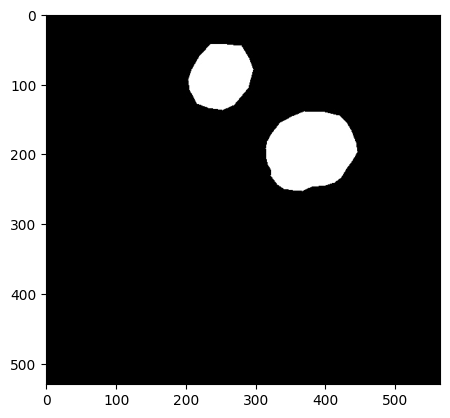

In [8]:
plt.imshow(gray,cmap='gray')

In [9]:
np.unique(gray)

array([  0,   1,   2,   3,   4,   5,   6,   7, 249, 250, 251, 252, 253,
       254, 255], dtype=uint8)

In [10]:
bbox_coords

{'0b556d02-f9ca-4270-b568-3200335c7d08': array([312, 136, 448, 256])}

In [2]:
img_path=sorted(glob.glob('/media/rohit/mirlproject2/fetal head circumference/1segmented-images/segmented-images/images/*'))
mask_path=sorted(glob.glob('/media/rohit/mirlproject2/fetal head circumference/1segmented-images/segmented-images/masks/*'))

print(len(mask_path))
print(mask_path[0])

1000
/media/rohit/mirlproject2/fetal head circumference/1segmented-images/segmented-images/masks/0004a718-546c-41c2-9c69-c4685093a039.jpg


In [3]:
base=os.path.basename(mask_path[-1])
a='_'.join(base.split('_')[:2])
base

'fff2bc86-e6ad-4ce5-989a-ab63a1c096b3.jpg'

In [4]:
'''
# Define the main dataset paths
main_images_path = '/media/rohit/mirlproject2/fetal head circumference/1segmented-images/segmented-images/images'
main_masks_path = '/media/rohit/mirlproject2/fetal head circumference/1segmented-images/segmented-images/masks'

# Define the training and validation dataset paths
training_images_path = '/media/rohit/mirlproject2/fetal head circumference/1segmented-images/train/imgs'
training_masks_path = '/media/rohit/mirlproject2/fetal head circumference/1segmented-images/train/masks'
validation_images_path = '/media/rohit/mirlproject2/fetal head circumference/1segmented-images/val/imgs'
validation_masks_path = '/media/rohit/mirlproject2/fetal head circumference/1segmented-images/val/masks'

# List files and create a list of base filenames
all_files = [f for f in os.listdir(main_images_path)]
base_filenames = [os.path.splitext(f)[0] for f in all_files]

# Shuffle indices
indices = list(range(len(base_filenames)))
random.shuffle(indices)

# Split indices for training and validation
val_size = int(len(base_filenames) * 0.05)  
val_indices = indices[:val_size]
train_indices = indices[val_size:]

# Create validation dataset
for i in tqdm(val_indices):
    base_filename = f"{base_filenames[i]}.jpg"
    
    # Copy images and masks to validation folders
    shutil.copy(os.path.join(main_images_path, base_filename), os.path.join(validation_images_path, base_filename))
    shutil.copy(os.path.join(main_masks_path, base_filename), os.path.join(validation_masks_path, base_filename))

# Create training dataset
for i in tqdm(train_indices):
    base_filename = f"{base_filenames[i]}.jpg"

    
    # Copy images and masks to training folders
    shutil.copy(os.path.join(main_images_path, base_filename), os.path.join(training_images_path, base_filename))
    shutil.copy(os.path.join(main_masks_path, base_filename), os.path.join(training_masks_path, base_filename))
    '''

'\n# Define the main dataset paths\nmain_images_path = \'/media/rohit/mirlproject2/fetal head circumference/1segmented-images/segmented-images/images\'\nmain_masks_path = \'/media/rohit/mirlproject2/fetal head circumference/1segmented-images/segmented-images/masks\'\n\n# Define the training and validation dataset paths\ntraining_images_path = \'/media/rohit/mirlproject2/fetal head circumference/1segmented-images/train/imgs\'\ntraining_masks_path = \'/media/rohit/mirlproject2/fetal head circumference/1segmented-images/train/masks\'\nvalidation_images_path = \'/media/rohit/mirlproject2/fetal head circumference/1segmented-images/val/imgs\'\nvalidation_masks_path = \'/media/rohit/mirlproject2/fetal head circumference/1segmented-images/val/masks\'\n\n# List files and create a list of base filenames\nall_files = [f for f in os.listdir(main_images_path)]\nbase_filenames = [os.path.splitext(f)[0] for f in all_files]\n\n# Shuffle indices\nindices = list(range(len(base_filenames)))\nrandom.shuff

In [5]:
training_images_path = '/media/rohit/mirlproject2/fetal head circumference/1segmented-images/train/imgs'
training_masks_path = '/media/rohit/mirlproject2/fetal head circumference/1segmented-images/train/masks'
validation_images_path = '/media/rohit/mirlproject2/fetal head circumference/1segmented-images/val/imgs'
validation_masks_path = '/media/rohit/mirlproject2/fetal head circumference/1segmented-images/val/masks'

In [6]:
print(len(os.listdir(training_images_path)))
print(len(os.listdir(training_masks_path)))

print(len(os.listdir(validation_images_path)))
print(len(os.listdir(validation_masks_path)))

950
950
50
50


96b2a75d-95f1-4336-a30e-600426da2551.jpg


(-0.5, 569.5, 529.5, -0.5)

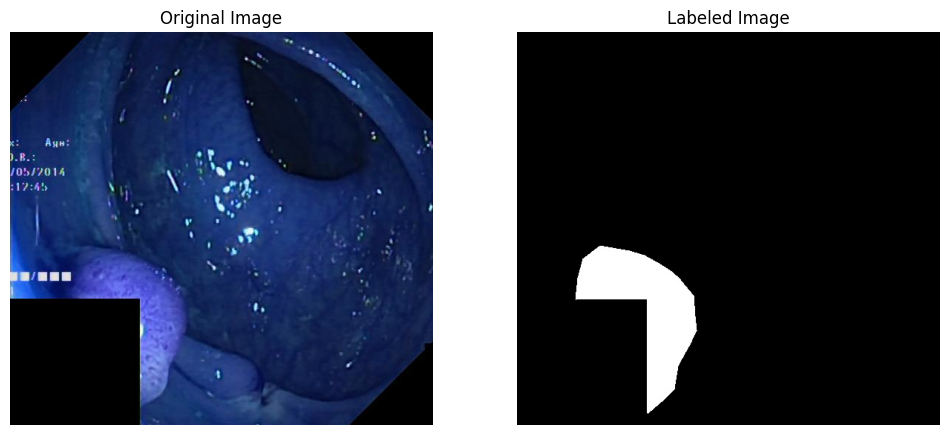

In [7]:
imgs=sorted(glob.glob('/media/rohit/mirlproject2/fetal head circumference/1segmented-images/train/imgs/*'))
masks=sorted(glob.glob('/media/rohit/mirlproject2/fetal head circumference/1segmented-images/train/masks/*'))

import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

random.shuffle(masks)

'''
for c in range(len(masks)):
    mask=cv2.imread(masks[c])
    unique_values = np.unique(mask)
    
    # Only show the slice if it has non-zero unique values
    if np.any(unique_values != 0):
        i=c
        break
        
'''

c=0

basename=os.path.basename(masks[c])
print(basename)
img=cv2.imread(os.path.join('/media/rohit/mirlproject2/fetal head circumference/1segmented-images/train/imgs',basename))


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
img=img
plt.imshow(img,cmap='bone')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
mask=cv2.imread(masks[c])
label=mask
plt.imshow(label, cmap='gray')
plt.title('Labeled Image')
plt.axis('off')

b74525ed-48ec-4259-915f-1234c47c649f.jpg


(-0.5, 573.5, 529.5, -0.5)

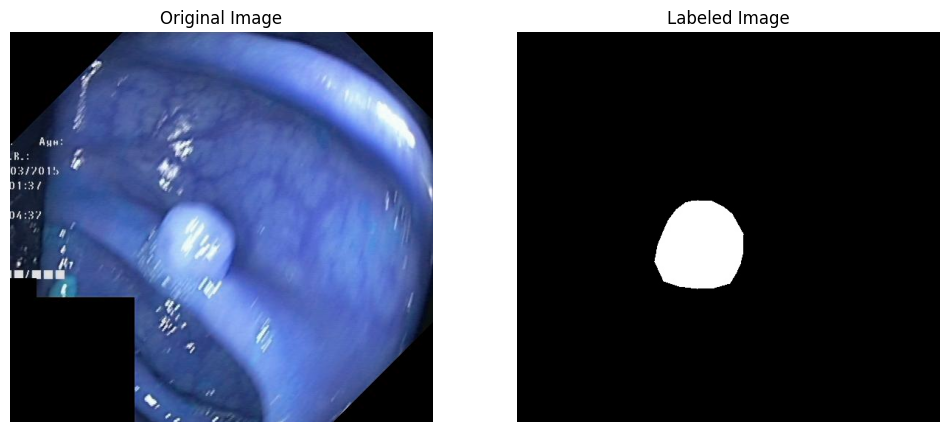

In [8]:
imgs=sorted(glob.glob('/media/rohit/mirlproject2/fetal head circumference/1segmented-images/val/imgs/*'))
masks=sorted(glob.glob('/media/rohit/mirlproject2/fetal head circumference/1segmented-images/val/masks/*'))

import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

random.shuffle(masks)

'''
for c in range(len(masks)):
    mask=cv2.imread(masks[c])
    unique_values = np.unique(mask)
    
    # Only show the slice if it has non-zero unique values
    if np.any(unique_values != 0):
        i=c
        break
        
'''

c=0

basename=os.path.basename(masks[c])
print(basename)
img=cv2.imread(os.path.join('/media/rohit/mirlproject2/fetal head circumference/1segmented-images/val/imgs',basename))


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
img=img
plt.imshow(img,cmap='bone')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
mask=cv2.imread(masks[c])
label=mask
plt.imshow(label, cmap='gray')
plt.title('Labeled Image')
plt.axis('off')

In [9]:
f='f0db9c13-36f3-4718-971a-b226d1ff2e4a.jpg'
k=f[:-4]
k

'f0db9c13-36f3-4718-971a-b226d1ff2e4a'

In [10]:
import os
bbox_coords = {}
files = os.listdir("/media/rohit/mirlproject2/fetal head circumference/1segmented-images/train/masks")
for counter,f in enumerate(files):
  #if "Annotation" in f:
  k = f[:-4]
  im = cv2.imread("/media/rohit/mirlproject2/fetal head circumference/1segmented-images/train/masks/"+f)
  gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
  contours, hierarchy = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
  largest_contour = max(contours, key=cv2.contourArea)
  x,y,w,h = cv2.boundingRect(largest_contour)
  height, width, _ = im.shape
  bbox_coords[k] = np.array([0, 0, width, height])

bbox_coords_val={}
files = os.listdir("/media/rohit/mirlproject2/fetal head circumference/1segmented-images/val/masks")
for counter,f in enumerate(files):
  #if "Annotation" in f:
  k = f[:-4]
  im = cv2.imread("/media/rohit/mirlproject2/fetal head circumference/1segmented-images/val/masks/"+f)
  gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
  contours, hierarchy = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
  largest_contour = max(contours, key=cv2.contourArea)
  x,y,w,h = cv2.boundingRect(largest_contour)
  height, width, _ = im.shape
  bbox_coords_val[k] = np.array([0, 0, width, height])



In [11]:
im.shape

(506, 601, 3)

In [12]:
next(iter(bbox_coords.items()))

('4764e74f-4bf7-4841-8fb5-835c4fac1450', array([  0,   0, 571, 530]))

In [13]:
import cv2
import numpy as np
import os

def find_combined_bounding_box(image_path, min_area_threshold=100):
    # Load the image
    im = cv2.imread(image_path)

    height, width, _ = im.shape

    # Convert to grayscale
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    # Find contours
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out contours that are too small
    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area_threshold]

    # If there's only one valid contour, get its bounding box
    if len(valid_contours) == 1:
        x, y, w, h = cv2.boundingRect(valid_contours[0])
        return np.array([x, y, x+w, y+h])

    # If there are multiple contours, combine them into one bounding box
    x_min = min([cv2.boundingRect(cnt)[0] for cnt in valid_contours])
    y_min = min([cv2.boundingRect(cnt)[1] for cnt in valid_contours])
    x_max = max([cv2.boundingRect(cnt)[0] + cv2.boundingRect(cnt)[2] for cnt in valid_contours])
    y_max = max([cv2.boundingRect(cnt)[1] + cv2.boundingRect(cnt)[3] for cnt in valid_contours])
    
    return np.array([x_min, y_min, x_max, y_max])

def get_bounding_boxes_for_directory(directory_path):
    bbox_coords = {}
    files = os.listdir(directory_path)
    for counter, f in enumerate(files):
        if f.endswith(".jpg"):  # Ensure we are only processing image files
            k = f[:-4]
            bbox = find_combined_bounding_box(os.path.join(directory_path, f))
            bbox_coords[k] = bbox
    return bbox_coords

# Assuming these are the correct paths in your filesystem
train_masks_dir = "/media/rohit/mirlproject2/fetal head circumference/1segmented-images/train/masks"
val_masks_dir = "/media/rohit/mirlproject2/fetal head circumference/1segmented-images/val/masks"

# Get bounding boxes for training masks
bbox_coords = get_bounding_boxes_for_directory(train_masks_dir)

# Get bounding boxes for validation masks
bbox_coords_val = get_bounding_boxes_for_directory(val_masks_dir)

#(bbox_coords_train, bbox_coords_val)


In [14]:
import cv2
import os

ground_truth_masks = {}
for k in bbox_coords.keys():
    file_path = '/media/rohit/mirlproject2/fetal head circumference/1segmented-images/train/masks/' + k + '.jpg'
    
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"File does not exist: {file_path}")
        continue
    
    # Attempt to read the file
    gt_grayscale = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    # Check if the file was read successfully
    if gt_grayscale is None:
        print(f"Failed to read the file: {file_path}")
        continue
    
    ground_truth_masks[k] = (gt_grayscale == 255)


In [15]:
ground_truth_masks = {}
for k in bbox_coords.keys():
  gt_grayscale = cv2.imread('/media/rohit/mirlproject2/fetal head circumference/1segmented-images/train/masks/'+k+'.jpg', cv2.IMREAD_GRAYSCALE)
  ground_truth_masks[k] = (gt_grayscale == 255)

In [16]:
ground_truth_masks_val = {}
for k in bbox_coords_val.keys():
  gt_grayscale = cv2.imread(f'/media/rohit/mirlproject2/fetal head circumference/1segmented-images/val/masks/{k}.jpg', cv2.IMREAD_GRAYSCALE)
  ground_truth_masks_val[k] = (gt_grayscale == 255)

## Take a look at the images, the bounding box prompts and the ground truth segmentation masks

In [17]:
# Helper functions provided in https://github.com/facebookresearch/segment-anything/blob/9e8f1309c94f1128a6e5c047a10fdcb02fc8d651/notebooks/predictor_example.ipynb
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

We can see here that the ground truth mask is extremely tight which will be good for calculating an accurate loss.
The bounding box overlaid will be a good prompt.

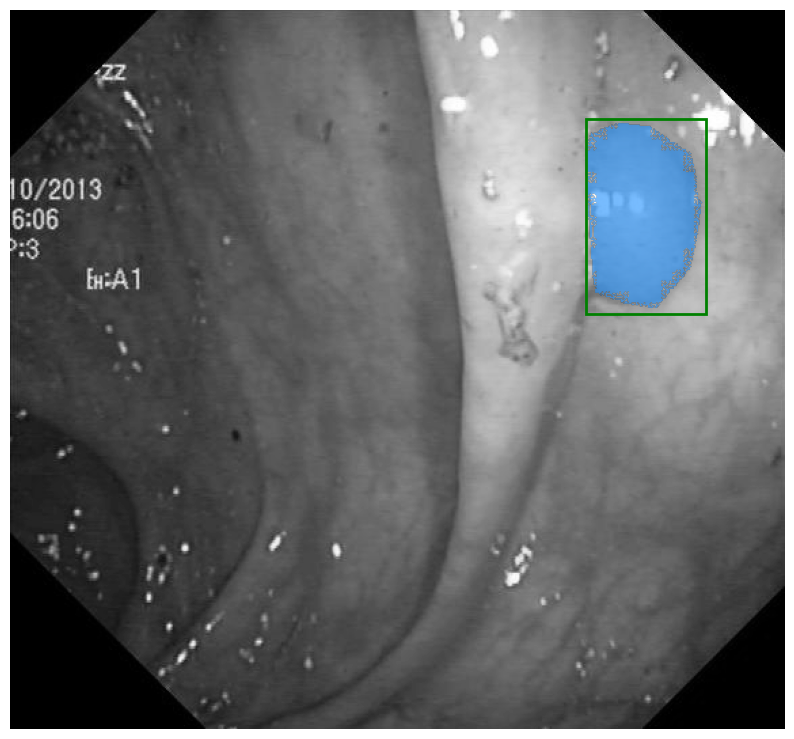

In [18]:
name = '4764e74f-4bf7-4841-8fb5-835c4fac1450'
image = cv2.imread(f'/media/rohit/mirlproject2/fetal head circumference/1segmented-images/train/imgs/4764e74f-4bf7-4841-8fb5-835c4fac1450.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray')
show_box(bbox_coords[name], plt.gca())
show_mask(ground_truth_masks[name], plt.gca())
plt.axis('off')
plt.show()

In [19]:
cv2.imread('/media/rohit/mirlproject2/fetal head circumference/1segmented-images/train/imgs/f665a5e76-2496-46ba-acd5-a472672160d3.jpg')

[ WARN:0@33.527] global loadsave.cpp:241 findDecoder imread_('/media/rohit/mirlproject2/fetal head circumference/1segmented-images/train/imgs/f665a5e76-2496-46ba-acd5-a472672160d3.jpg'): can't open/read file: check file path/integrity


5b988661-9fc0-409c-af44-4ef37ea605e1.jpg
5b988661-9fc0-409c-af44-4ef37ea605e1
[184 251 344 392]


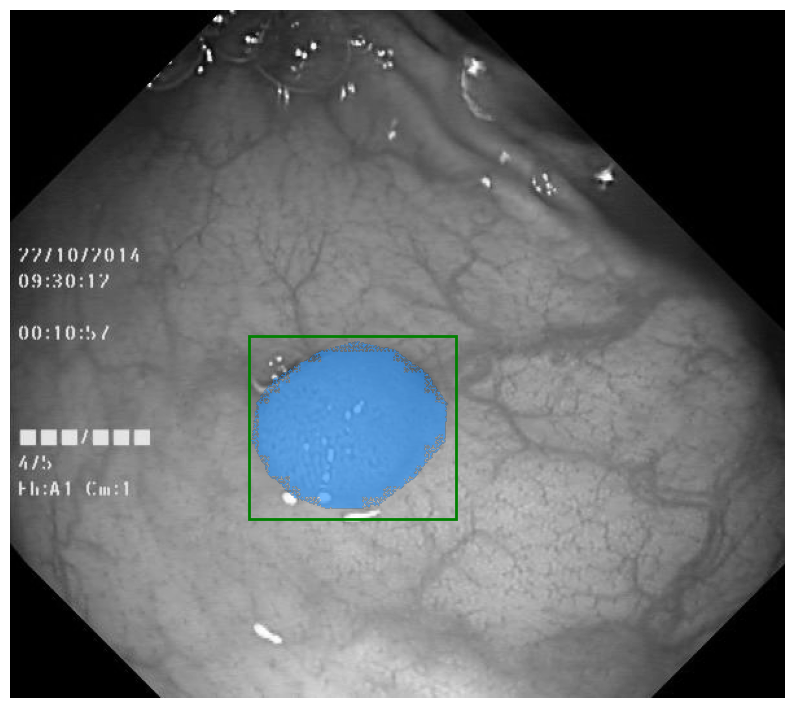

In [20]:
imgs=sorted(glob.glob('/media/rohit/mirlproject2/fetal head circumference/1segmented-images/train/imgs/*'))
masks=sorted(glob.glob('/media/rohit/mirlproject2/fetal head circumference/1segmented-images/train/masks/*'))

import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

random.shuffle(masks)


c=0

basename=os.path.basename(masks[c])


name = basename.split('.')[0]
print(basename)
print(name)
print(bbox_coords[name])
image = cv2.imread(f'/media/rohit/mirlproject2/fetal head circumference/1segmented-images/train/imgs/{basename}')
image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray')
show_box(bbox_coords[name], plt.gca())
show_mask(ground_truth_masks[name], plt.gca())
plt.axis('off')
plt.show()

## Prepare Fine Tuning

In [23]:
model_type = 'vit_h'
checkpoint = './sam_vit_h_4b8939.pth'
device = 'cuda'

In [24]:
checkpoint_tuned = 'weights/exp_2_vit_b.pth'

In [25]:
torch.__version__

'1.13.1+cu116'

In [26]:
import torch
torch.cuda.is_available()
#torch.cuda.get_device_name(0)

True

In [27]:
device = 'cuda'
from segment_anything import SamPredictor, sam_model_registry
sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
sam_model.train()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
      (1): Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, b

We convert the input images into a format SAM's internal functions expect.

In [22]:
for k in bbox_coords.keys():
  thing = "_".join(k.split('_')[:-1])
  print(k)
  #print(thing)
  break

4764e74f-4bf7-4841-8fb5-835c4fac1450


In [23]:
for k in bbox_coords.keys():
  thing = "_".join(k.split('_')[:-1])
  print(thing)
  break

In [28]:
# Preprocess the images
from collections import defaultdict

import torch

from segment_anything.utils.transforms import ResizeLongestSide

transformed_data = defaultdict(dict)
for k in bbox_coords.keys():
  thing = k #"_".join(k.split('_')[:-1])
  image = cv2.imread(f'/media/rohit/mirlproject2/fetal head circumference/1segmented-images/train/imgs/{thing}.jpg')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  transform = ResizeLongestSide(sam_model.image_encoder.img_size)
  input_image = transform.apply_image(image)
  input_image_torch = torch.as_tensor(input_image, device=device)
  transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

  input_image = sam_model.preprocess(transformed_image)
  original_image_size = image.shape[:2]
  input_size = tuple(transformed_image.shape[-2:])

  transformed_data[k]['image'] = input_image
  transformed_data[k]['input_size'] = input_size
  transformed_data[k]['original_image_size'] = original_image_size

In [29]:
import torch.nn.functional as F

def dice_pytorch(inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice


In [26]:
# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-4
wd = 0
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)

loss_fn = dice_pytorch
keys = list(bbox_coords.keys())

## Run fine tuning

In [27]:
from statistics import mean

from tqdm import tqdm
from torch.nn.functional import threshold, normalize

num_epochs = 100
losses = []

for epoch in range(num_epochs):
  epoch_losses = []
  for k in keys:
    input_image = transformed_data[k]['image'].to(device)
    input_size = transformed_data[k]['input_size']
    original_image_size = transformed_data[k]['original_image_size']

    # No grad here as we don't want to optimise the encoders
    with torch.no_grad():
      image_embedding = sam_model.image_encoder(input_image)

      prompt_box = bbox_coords[k]
      box = transform.apply_boxes(prompt_box, original_image_size)
      box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
      box_torch = box_torch[None, :]

      sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
          points=None,
          boxes=box_torch,
          masks=None,
      )
    low_res_masks, iou_predictions = sam_model.mask_decoder(
      image_embeddings=image_embedding,
      image_pe=sam_model.prompt_encoder.get_dense_pe(),
      sparse_prompt_embeddings=sparse_embeddings,
      dense_prompt_embeddings=dense_embeddings,
      multimask_output=False,
    )

    upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
    #binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))
    binary_mask = torch.sigmoid(upscaled_masks)
    gt_mask_resized = torch.from_numpy(np.resize(ground_truth_masks[k], (1, 1, ground_truth_masks[k].shape[0], ground_truth_masks[k].shape[1]))).to(device)
    gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)

    loss = loss_fn(binary_mask, gt_binary_mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
  losses.append(epoch_losses)
  print(f'EPOCH: {epoch}')
  print(f'Mean loss: {mean(epoch_losses)}')
  torch.save(sam_model.state_dict(), '/media/rohit/mirlproject2/fetal head circumference/1segmented-images/weights_polyb/thesis_case_1_vit_h_box_size_vit_b.pth')

EPOCH: 0
Mean loss: 0.0737606430053711
EPOCH: 1
Mean loss: 0.06813660703207317
EPOCH: 2
Mean loss: 0.0599326387204622
EPOCH: 3
Mean loss: 0.058598797070352655
EPOCH: 4
Mean loss: 0.0627938259275336
EPOCH: 5
Mean loss: 0.05395756570916427


KeyboardInterrupt: 

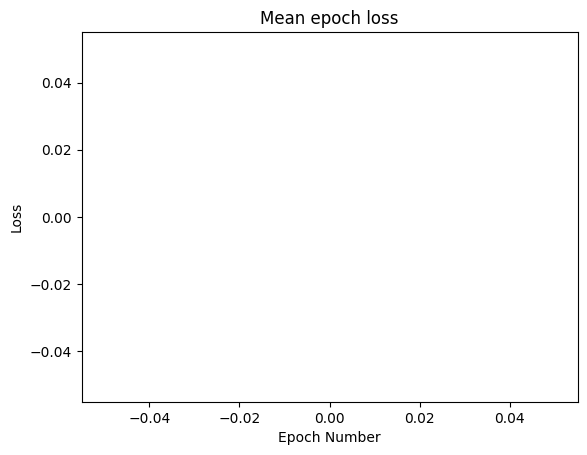

: 

In [27]:
mean_losses = [mean(x) for x in losses]
mean_losses

plt.plot(list(range(len(mean_losses))), mean_losses)
plt.title('Mean epoch loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')

plt.show()

## We can compare our tuned model to the original model

In [30]:
checkpoint = './sam_vit_h_4b8939.pth'

In [31]:
device = 'cuda'
model_type = 'vit_h'
from segment_anything import SamPredictor, sam_model_registry
sam_model_orig = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model_orig.to(device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
      (1): Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, b

In [32]:
checkpoint1='/media/rohit/mirlproject2/fetal head circumference/1segmented-images/weights_polyb/thesis_case_1_vit_h_box_size_vit_b.pth'
sam_model = sam_model_registry[model_type](checkpoint=checkpoint1)
sam_model.to(device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
      (1): Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, b

In [33]:
# Set up predictors for both tuned and original models
from segment_anything import sam_model_registry, SamPredictor
predictor_tuned = SamPredictor(sam_model)
predictor_original = SamPredictor(sam_model_orig)

In [34]:
key_to_find = 'e9f9891a-154b-4581-be44-402b7630d323'
keys_list = list(bbox_coords_val.keys())
index_of_key = keys_list.index(key_to_find)

print(index_of_key)

27


In [35]:

k =list(bbox_coords_val.keys())[26]


thing = k #"_".join(k.split('_')[:-1])
image = cv2.imread(f'/media/rohit/mirlproject2/fetal head circumference/1segmented-images/val/imgs/{thing}.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor_tuned.set_image(image)
predictor_original.set_image(image)

input_bbox = np.array(bbox_coords_val[k])

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB (GPU 0; 23.47 GiB total capacity; 20.64 GiB already allocated; 679.75 MiB free; 20.95 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

: 

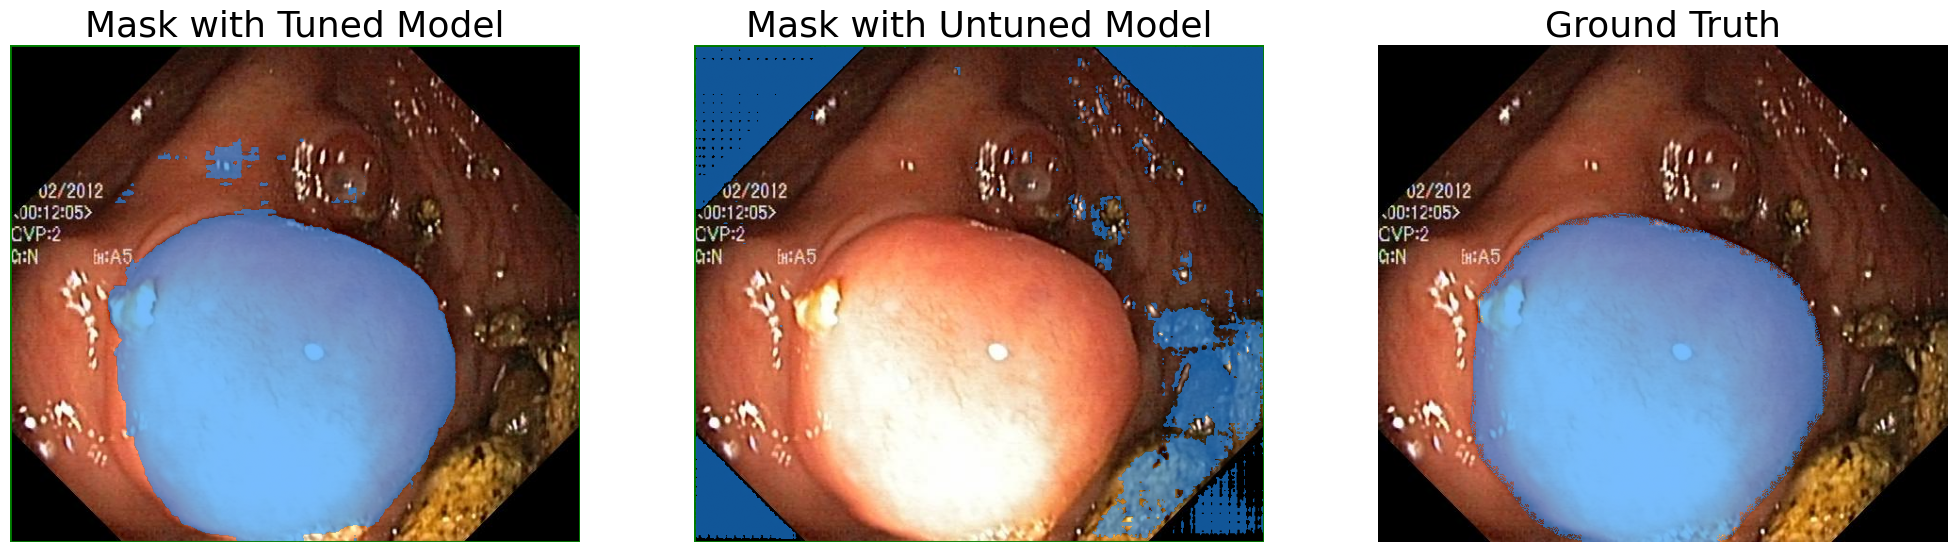

In [54]:
%matplotlib inline
_, axs = plt.subplots(1, 3, figsize=(25, 25))


axs[0].imshow(image)
show_mask(masks_tuned, axs[0])
show_box(input_bbox, axs[0])
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')


axs[1].imshow(image)
show_mask(masks_orig, axs[1])
show_box(input_bbox, axs[1])
axs[1].set_title('Mask with Untuned Model', fontsize=26)
axs[1].axis('off')

axs[2].imshow(image)
show_mask(ground_truth_masks_val[k], axs[2])
#show_box(bbox_coords_val[k], axs[2])
axs[2].set_title('Ground Truth', fontsize=26)
axs[2].axis('off')

plt.show()

In [55]:
import numpy as np

def dice_score(true_mask, pred_mask):
    # Ensuring the masks are 2D
    if true_mask.ndim > 2:
        true_mask = true_mask.squeeze()
    if pred_mask.ndim > 2:
        pred_mask = pred_mask.squeeze()

    intersection = np.sum(pred_mask[true_mask == True])
    true_sum = np.sum(true_mask)
    pred_sum = np.sum(pred_mask)
    
    if (true_sum + pred_sum) == 0:
        return 1
    return 2. * intersection / (true_sum + pred_sum)


In [56]:
dice_score(masks_tuned, ground_truth_masks_val[k])

0.9583331333426129

In [60]:
dice_score(masks_orig, ground_truth_masks_val[k])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 506 but corresponding boolean dimension is 528

: 

In [57]:
len(bbox_coords_val)

50

In [58]:
tuned_dice=[]
untuned_dice=[]


for i in range(len(bbox_coords_val)):

    k =list(bbox_coords_val.keys())[i]
    thing = k #"_".join(k.split('_')[:-1])
    image = cv2.imread(f'/media/rohit/mirlproject2/fetal head circumference/1segmented-images/val/imgs/{thing}.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    predictor_tuned.set_image(image)
    predictor_original.set_image(image)

    input_bbox = np.array(bbox_coords_val[k])

    masks_tuned, _, _ = predictor_tuned.predict(
        point_coords=None,
        box=input_bbox,
        multimask_output=False,
    )

    masks_untuned, _, _ = predictor_original.predict(
        point_coords=None,
        box=input_bbox,
        multimask_output=False,
    )

    tuned_dice.append(dice_score(masks_tuned, ground_truth_masks_val[k]))
    untuned_dice.append(dice_score(masks_untuned, ground_truth_masks_val[k]))

In [59]:
print(np.average(tuned_dice))
print(np.average(untuned_dice))

0.7379325126947771
0.0515760198138591


In [50]:
!pip install glob

ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob


In [51]:
import numpy as np
import cv2
import glob
from tqdm import tqdm

# Termination criteria for corner refinement
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Checkerboard dimensions (number of inner corners)
checkerboard_size = (6, 9)

# Prepare object points: (0,0,0), (1,0,0), (2,0,0), ..., (checkerboard_size[0]-1, checkerboard_size[1]-1, 0)
objp = np.zeros((checkerboard_size[0]*checkerboard_size[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:checkerboard_size[1], 0:checkerboard_size[0]].T.reshape(-1,2)

# Arrays to store object points and image points
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane

# Path to the directory containing calibration images
images = glob.glob('/media/rohit/mirlproject2/fetal head circumference/1segmented-images/Qunal/*.jpg')

for fname in tqdm(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, None)

    # If found, add object points, image points (after refining them)
    if ret:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, checkerboard_size, corners2, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

if objpoints and imgpoints:
    # Camera calibration
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    # Save the camera matrix and distortion coefficients
    np.savez('/content/drive/MyDrive/Lapcole/Video_Processing/Camera calibration/calibration_data.npz', mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs)

    print("Calibration is complete. Camera matrix and distortion coefficients are saved.")
else:
    print("Calibration could not be completed because no object points or image points were found.")


0it [00:00, ?it/s]

Calibration could not be completed because no object points or image points were found.


In [52]:
images = glob.glob('/media/rohit/mirlproject2/fetal head circumference/1segmented-images/Qunal/*.jpg')
images

[]

## Without Finetuning

In [ ]:
# SAM
model_type = 'vit_h'
checkpoint = './sam_vit_h_4b8939.pth'
device = 'cuda'

from segment_anything import SamPredictor, sam_model_registry
sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
predictor = SamPredictor(sam_model)